# Crypto Predictions based on Indicators with XGBoost

This notebook is using tradeview.com data with various indicators to determine which indicators are the strongest.

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

/Users/rachelbates/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(250,250,250,0.8)'
)

fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [4]:
# Import the data into a Pandas Dataframe
btc_df = pd.read_csv(
    Path('csv_files/BTC/BTCUSD_15_minute.csv'), 
    infer_datetime_format=True, 
    parse_dates=True
)


btc_df['time'] = pd.to_datetime(btc_df['time'])
btc_df.index = range(len(btc_df))
img_name = 'btc_'

# Review the DataFrame
btc_df

,time,open,high,low,close,Plot,Up Trend,Down Trend,VWAP,Upper Band,...,Lower Bollinger Band,Histogram,MACD,Signal,CCI,Smoothing Line.1,ADX,+DI,-DI,CHOP
0,2022-03-26 06:00:00+00:00,44575.67,44616.73,44525.73,44532.79,44554.230,NaN,44626.391130,44415.546708,44505.024029,...,NaN,12.970594,34.036683,21.066089,122.771498,100.900157,10.839469,19.686738,16.636541,44.722250
1,2022-03-26 06:15:00+00:00,44532.62,44557.03,44512.46,44546.31,44539.465,NaN,44626.391130,44417.861203,44508.055731,...,NaN,11.454436,35.384134,23.929698,99.433911,107.309706,10.447376,19.015719,17.084308,49.338998
2,2022-03-26 06:30:00+00:00,44546.32,44572.25,44512.33,44513.36,44529.840,NaN,44626.391130,44419.647298,44510.257985,...,NaN,7.582723,33.408101,25.825379,87.464649,110.606683,10.310160,19.315983,16.280870,56.332349
3,2022-03-26 06:45:00+00:00,44514.56,44518.63,44454.35,44518.63,44516.595,NaN,44626.391130,44420.976668,44511.369695,...,NaN,4.859383,31.899607,27.040224,36.706032,95.529171,9.902745,18.320615,20.089938,55.009789
4,2022-03-26 07:00:00+00:00,44528.40,44546.35,44456.71,44494.41,44511.405,NaN,44626.391130,44423.308522,44513.331046,...,NaN,1.105525,28.422130,27.316605,34.739169,76.223052,9.304608,19.225893,18.646880,62.123423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,2022-04-16 20:45:00+00:00,40287.77,40452.09,40277.90,40344.40,40316.085,NaN,40462.815705,40424.487716,40567.995465,...,NaN,16.618698,-14.807783,-31.426482,163.776853,99.709651,19.899062,25.981929,14.467529,46.245247
2076,2022-04-16 21:00:00+00:00,40346.44,40401.62,40346.44,40363.96,40355.200,NaN,40462.815705,40423.848234,40566.619911,...,NaN,18.811861,-7.911655,-26.723516,159.568019,111.601904,20.510996,24.648751,13.725175,45.778872
2077,2022-04-16 21:15:00+00:00,40366.53,40445.70,40362.55,40438.40,40402.465,NaN,40462.815705,40423.810667,40566.259896,...,NaN,24.194564,3.519689,-20.674875,192.900268,134.819996,21.589438,26.757073,12.704966,47.811368
2078,2022-04-16 21:30:00+00:00,40453.75,40524.23,40420.76,40483.60,40468.675,40230.877211,NaN,40423.871823,40566.249117,...,NaN,29.373066,16.041458,-13.331609,228.791304,165.084942,23.330321,31.208490,11.554052,40.224396


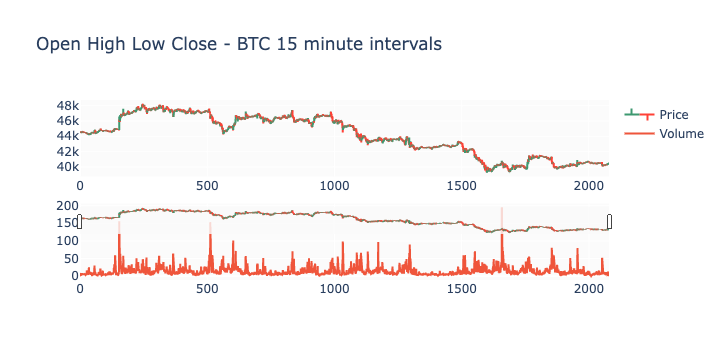

In [5]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=btc_df.index,
                      open=btc_df.open,
                      high=btc_df.high,
                      low=btc_df.low,
                      close=btc_df.close,
                      name='Price'), row=1, col=1)
fig.update_layout(
    title="Open High Low Close - BTC 15 minute intervals"
    )

fig.add_trace(go.Scatter(x=btc_df.index, y=btc_df.Volume, name='Volume'), row=2, col=1)
fig.update(layout_xaxis_rangeslider_visible=True)
fig.show()
fig.write_image(f'images/{img_name}ohlc.png')

In [6]:
df_close = btc_df[['time', 'close']].copy()
df_close = df_close.set_index('time')
df_close.head()

,close
time,
2022-03-26 06:00:00+00:00,44532.79
2022-03-26 06:15:00+00:00,44546.31
2022-03-26 06:30:00+00:00,44513.36
2022-03-26 06:45:00+00:00,44518.63
2022-03-26 07:00:00+00:00,44494.41


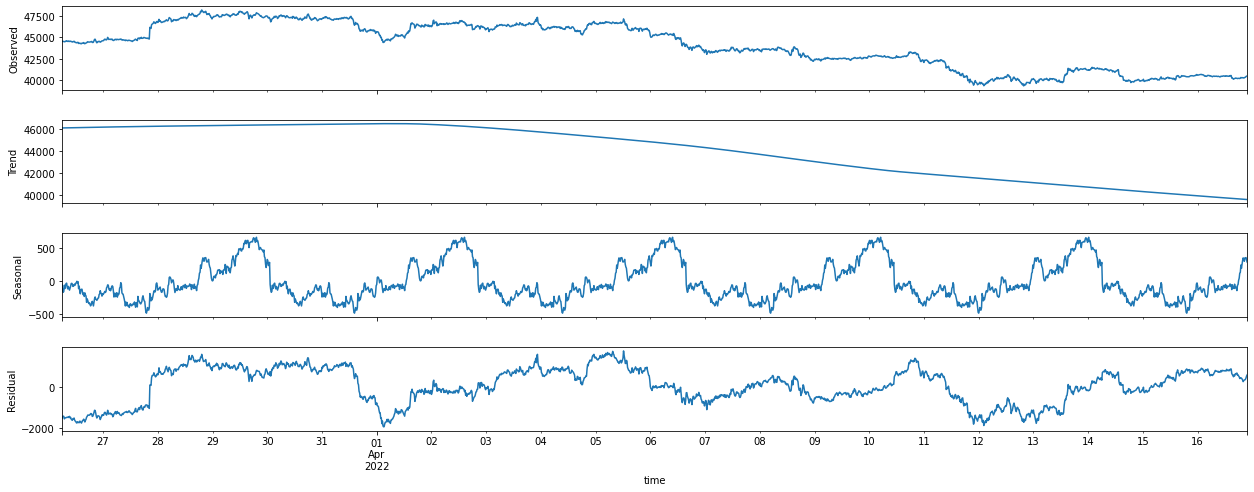

In [7]:
decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)
fig.savefig(f'images/{img_name}decomp.png')

### RSI to predict if the coin is overbought or over sold

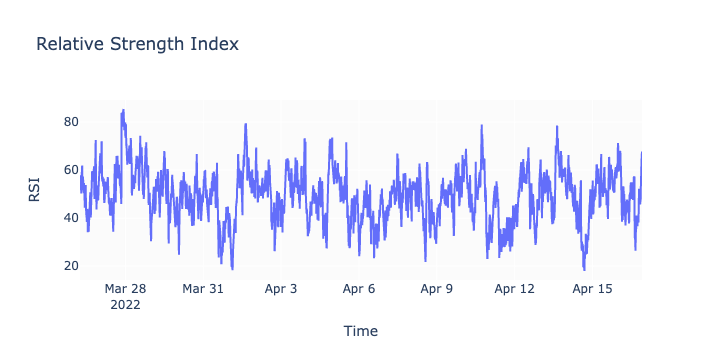

In [8]:
fig = go.Figure(go.Scatter(x=btc_df.time, y=btc_df.RSI, name='RSI'))
fig.update_layout(
    title='Relative Strength Index',
    xaxis_title='Time',
    yaxis_title='RSI'
    )
fig.show()
fig.write_image(f'images/{img_name}RSI.png')

### Indicators

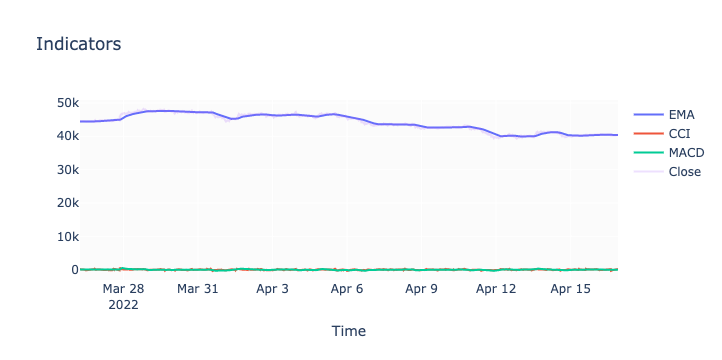

In [9]:
fig = go.Figure()
fig.update_layout(
    title='Indicators',
    xaxis_title='Time',
    )
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.EMA, name='EMA'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.CCI, name='CCI'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.MACD, name='MACD'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close, name='Close', opacity=0.2))
fig.show()
fig.write_image(f'images/{img_name}RSI.png')

Split stock data frame into two subsets: training ($70\%$)and test ($30\%$) sets. Calculated split indices and create separate dataframes (train_df, test_df). Frames have been ploted in the chart below.

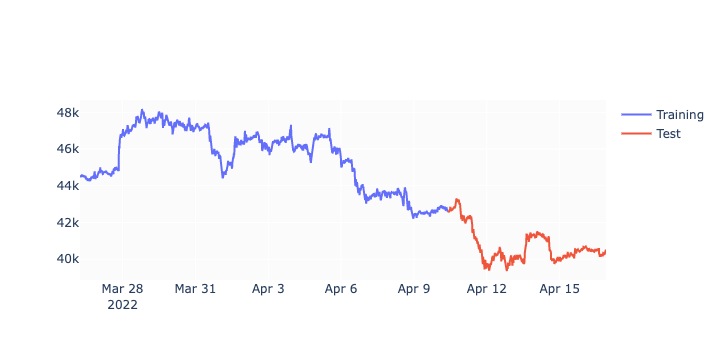

In [10]:
test_size  = 0.30
test_split_idx  = int(btc_df.shape[0] * (1-test_size))

train_df  = btc_df.loc[:test_split_idx - 1].copy()
test_df   = btc_df.loc[test_split_idx:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.time, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=test_df.time,  y=test_df.close,  name='Test'))
fig.show()
fig.write_image(f'images/{img_name}traintest.png')

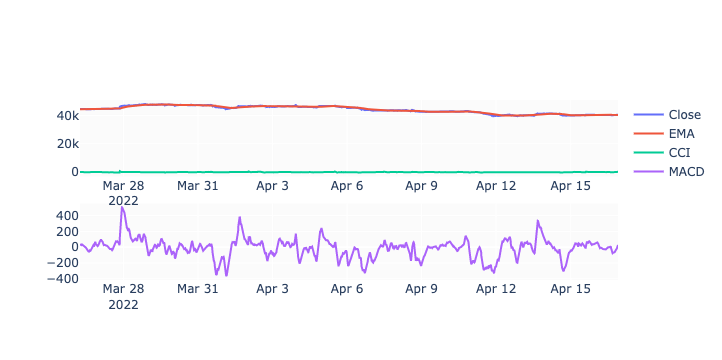

In [11]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['EMA'], name='EMA'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['CCI'], name='CCI'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['MACD'], name='MACD'), row=2, col=1)
fig.show()
fig.write_image(f'images/{img_name}MACD.png')

### Drop Unnessary Columns

In [12]:
# This code needs to be optimized, they are manually changed depending on the desired idicators 
drop_cols = ['time', 'open', 'low', 'high', 'Plot','Up Trend', 
             'Down Trend', 'VWAP', 'Upper Band', 'Lower Band', 
             'Basis', 'Upper', 'Lower', 'Smoothing Line', 'Lead 1',
             'Lead 2', 'Lower Bollinger Band', 'Histogram', 
             'Smoothing Line.1', 'ADX', '+DI', '-DI', 'CHOP', 
             'Lagging Span', 'Volume', 'Volume MA', 'Upper Bollinger Band',
            'Signal', 'RSI-based MA', 'Tenkan', 'Kijun', 'RSI']

train_df = train_df.drop(drop_cols, axis=1).dropna()
test_df = test_df.drop(drop_cols, axis=1).dropna()

In [13]:
train_df.head()

,close,EMA,MACD,CCI
0,44532.79,44439.966193,34.036683,122.771498
1,44546.31,44444.136538,35.384134,99.433911
2,44513.36,44446.851184,33.408101,87.464649
3,44518.63,44449.666039,31.899607,36.706032
4,44494.41,44451.420705,28.422130,34.739169


### Split into features and labels

In [14]:
y_train = train_df['close'].copy()
X_train = train_df.drop(columns = ['close'])

y_test = test_df['close'].copy()
X_test = test_df.drop(columns = ['close'])


### Fine Tune XGRegressor

In [15]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42],  
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)

print(train_df.info())
print(test_df.info())
print(model)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1456 non-null   float64
 1   EMA     1456 non-null   float64
 2   MACD    1456 non-null   float64
 3   CCI     1456 non-null   float64
dtypes: float64(4)
memory usage: 56.9 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 1456 to 2079
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   624 non-null    float64
 1   EMA     624 non-null    float64
 2   MACD    624 non-null    float64
 3   CCI     624 non-null    float64
dtypes: float64(4)
memory usage: 24.4 KB
None
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=Non

In [16]:
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 400, 'random_state': 42}


In [17]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

CPU times: user 8.39 s, sys: 2.26 s, total: 10.7 s
Wall time: 2.66 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

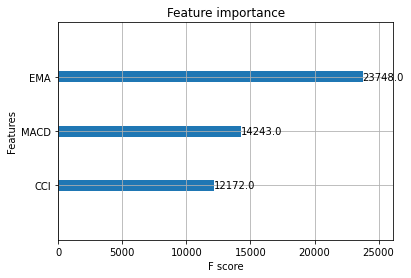

In [18]:
importance = plot_importance(model)
importance.figure.savefig(f'images/{img_name}importance.png')


### Calculate and Visualize Predictions

In [19]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [42601.81 42554.3  42579.55 42612.51 42636.3 ]
y_pred = [42405.36  42424.27  42395.707 42386.945 42404.875]


In [20]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 4306730.954418039


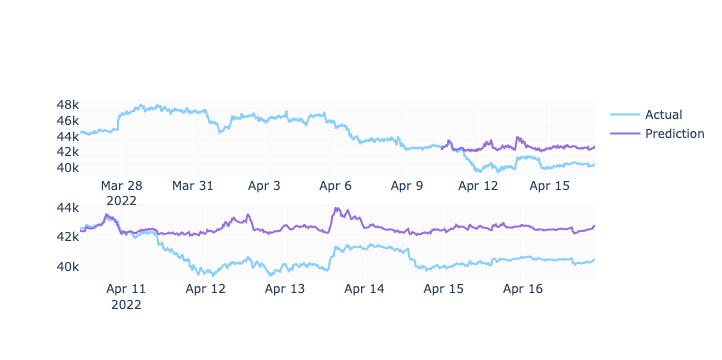

In [21]:
predicted_prices = btc_df.loc[test_split_idx:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close,
                         name='Actual',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_test,
                         name='Actual',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()
fig.write_image(f'images/{img_name}predictions.png')